# Project 2: Bipartite Graphs and Projections using Movies Dataset
By Shyam Balagurumurthy and Latif Masud

# Introduction

For this project, we chose to look at a dataset of movies and genre dataset. The dataset was taken from [Kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata/data) containing different moviews and their genre category information. Using this dataset, we have built out networkX bipartite graphs and performed graph projections and analysis

In [161]:
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
# %matplotlib notebook
import pandas as pd
import json
from collections import defaultdict
from itertools import combinations

# Data Cleanup and Loading
Original dataset contains movies, genre categories and some metrics of those movies. Some of the metrics are budget of the movied, popularity, votes count and average. We have selected the required measures and filtered out genre from JSON column.

In [162]:
def pipe_flatten_names(keywords):
    """Flatten the column of Genre"""
    return '|'.join([x['name'] for x in keywords])

To represent the graph in two different formats, we are using below defined two functions

In [163]:
def show_graph(graph):
    """One format of the chart in networkx"""
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    plt.show()

In [164]:
def draw_chart(G):

    """This function plots the chart according to the graph type. 
    If it is bipartite graph type, it shows the circular graph.
    
    If not it will show the random networkx graph."""
    if nx.is_bipartite(G):
        edge_width = [1 for u,v in G.edges()]
        node_color =[5 if G.node[g]['bipartite'] ==0 else 8 for g in G.nodes()]
        node_size = [G.degree(v) for v in G]
        pos = nx.circular_layout(G)

    else:
        node_color = [G.degree(v)*100 for v in G]
        node_size = [G.degree(v)*150 for v in G]
        if nx.is_weighted(G):
            edge_width = [1*G[u][v]['weight'] for u,v in G.edges()]
        else:
            edge_width = [1 for u,v in G.edges()]
        pos = nx.random_layout(G)
        
    plt.figure(figsize=(12,9))
    nx.draw_networkx(G, pos,node_color=node_color,alpha=0.5,with_labels=True, 
                    width=edge_width, edge_color ='.4',node_size=node_size)
    plt.show()

Trim edges trims the nodes and edges which has low weights. This function provides attributes of the node too.

In [165]:
def trim_edges (g, variable, weight=1):
    """Function used for trimming the edges based on the weights.
    Original function does not provide the attributes of the nodes. This function provides attributies too.
    """
    g2= nx.Graph()
    
    for f, to, edata in g.edges(data=True):
        if edata[variable] > weight:
            g2.add_edge(f,to,edata)
    
    # Adding the attributes of Node
    for node in g2.nodes():
        g2.add_node(node,bipartite= nx.get_node_attributes(g,'bipartite')[node])        
        
    return g2

Island method is used to create graph using various threshold level. This modified function allows to pass the weights variable name. So we can modify the variable dynamically. 

In [166]:
def island_method(g, variable, iterations=5):
    """Using island method, we are limiting the number of nodes and clusters. 
    It calls trim edges with a threshold value. 
    
    Output of this function is the list of graphs with different threshold level.
    """
    weights= [edata[variable] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    print(mx)
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g,variable, threshold)] for threshold in range(mn,mx,step)]

In [167]:
def sorted_map(map1):
    """Defined a function to sort the dictionary"""
    ms = sorted(map1.items(), key =lambda k: -k[1])
    return ms

In [168]:
def node_info(G):
    """Provides various information of that particular graph. It calculates the
    diameter, radius and other information"""
    
    print("\nNode information:{}".format(nx.info(G)))    
    print("\nGraph Diameter:{}".format(nx.diameter(G)))
    print("\nGraph Radius:{}".format(nx.radius(G)))

In [169]:
def recommendations(G):
    """Recommendations for that particular graph using combinations"""
    
    # Initialize the defaultdict: recommended
    recommended = defaultdict(int)
    
    # Iterate over all the nodes in G
    for n, d in G.nodes(data=True):
    
        # Iterate over all possible triangle relationship combinations
        for n1, n2 in combinations(G.neighbors(n), 2):
        
            # Check whether n1 and n2 do not have an edge
            if not G.has_edge(n1, n2):
            
                # Increment recommended
                recommended[(n1, n2)] += 1
    
    # Identify the top 10 pairs of users
    all_counts = sorted(recommended.values())
    top10_pairs = [pair for pair, count in recommended.items() if count > all_counts[-10]]
    return(top10_pairs)


In [170]:
def projections_graph(g,movie_list, genre_list):
    
    """Function which creates the projected graph on the movies and genre. It also creates weighted graph projections"""
    
    # projections without weight 
    movies_projected = bipartite.projected_graph(g, movie_list)
    genre_projected = bipartite.projected_graph(g, genre_list)
    
    # Movies without weight
    global movies_wgt_projected
    movies_wgt_projected = bipartite.weighted_projected_graph(g, movie_list)
    global genre_wgt_projected
    genre_wgt_projected = bipartite.weighted_projected_graph(g, genre_list)
    
    print("\nMovies which are similar to each other\n")
    show_graph(movies_projected)
    
    print("\nMovies recommendations\n {}".format(recommendations(movies_projected)))
    
    #show_graph(genre_projected)
    print("\nGenre recommendations\n {}".format(recommendations(genre_projected)))

    draw_chart(genre_projected)
    print("\nMovies which are similar to each other on weighted graph\n")
          
    print("\nMovies recommendations on weighted graph\n {}".format(recommendations(movies_projected)))
    show_graph(movies_wgt_projected)
    #draw_chart(movies_wgt_projected)
    print("\nGenre which are similar to each other on weighted graph\n")
    #show_graph(genre_wgt_projected)
    draw_chart(genre_wgt_projected)
    print("\nGenre recommendations on weighted graph\n {}".format(recommendations(genre_wgt_projected)))
          


In [173]:
def helping_function(G, variable, method="Y"):
    """Helping function to call all the other functions."""
    
    if nx.is_bipartite(G):
        node_info(G)
    else:
        
        #triange_edges(G)
        if(method =="Y"):
            result_island = island_method(G,variable)
            result_island = result_island[round(len(result_island)/2)][1]
            node_info(result_island)
            #nodes_analysis(result_island)
            
            #Creating separte movies and Genre category
            movie_list = [node[0] for node in result_island.nodes(data=True) if node[1]['bipartite']=='Movies']
            genre_list = [node[0] for node in result_island.nodes(data=True) if node[1]['bipartite']=='Genre']
            
            
            show_graph(result_island)
            projections_graph(result_island, movie_list,genre_list)
        elif(method=="N"):
            nodes_analysis(G)
            #draw_chart(G)
    return(result_island)

Below is the Main function which loads the dataset and performs data transformations. It also calls other functions with different parameters.

Projections using Budget:

380000000

Node information:Name: 
Type: Graph
Number of nodes: 119
Number of edges: 339
Average degree:   5.6975

Graph Diameter:5

Graph Radius:3


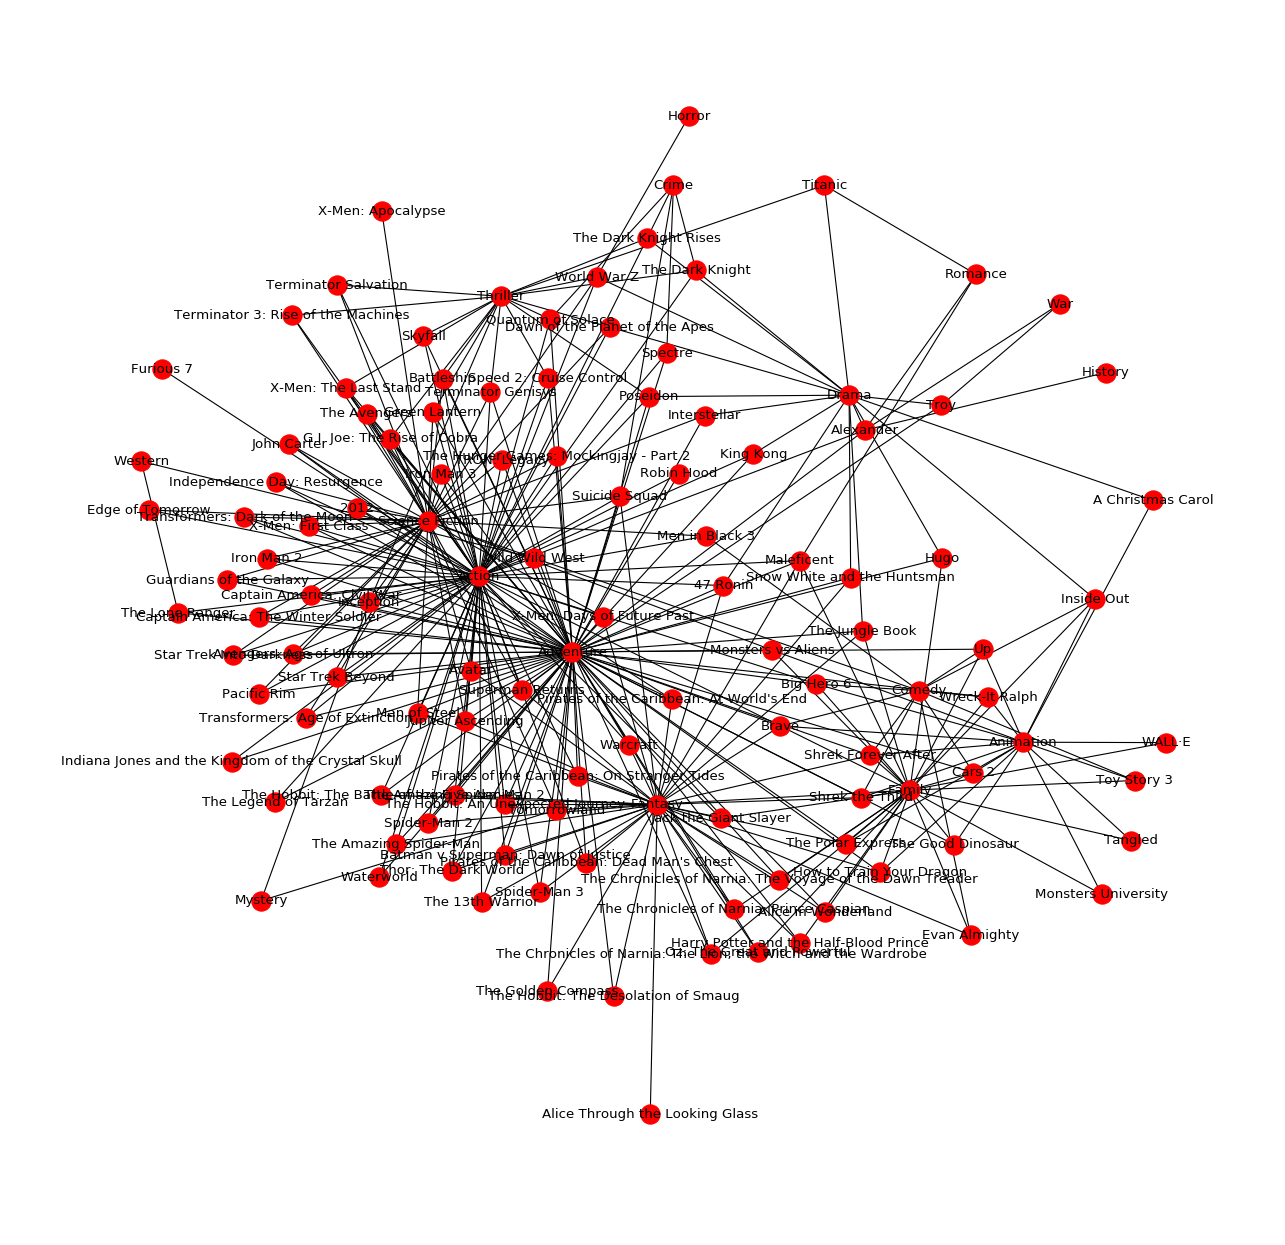


Movies which are similar to each other



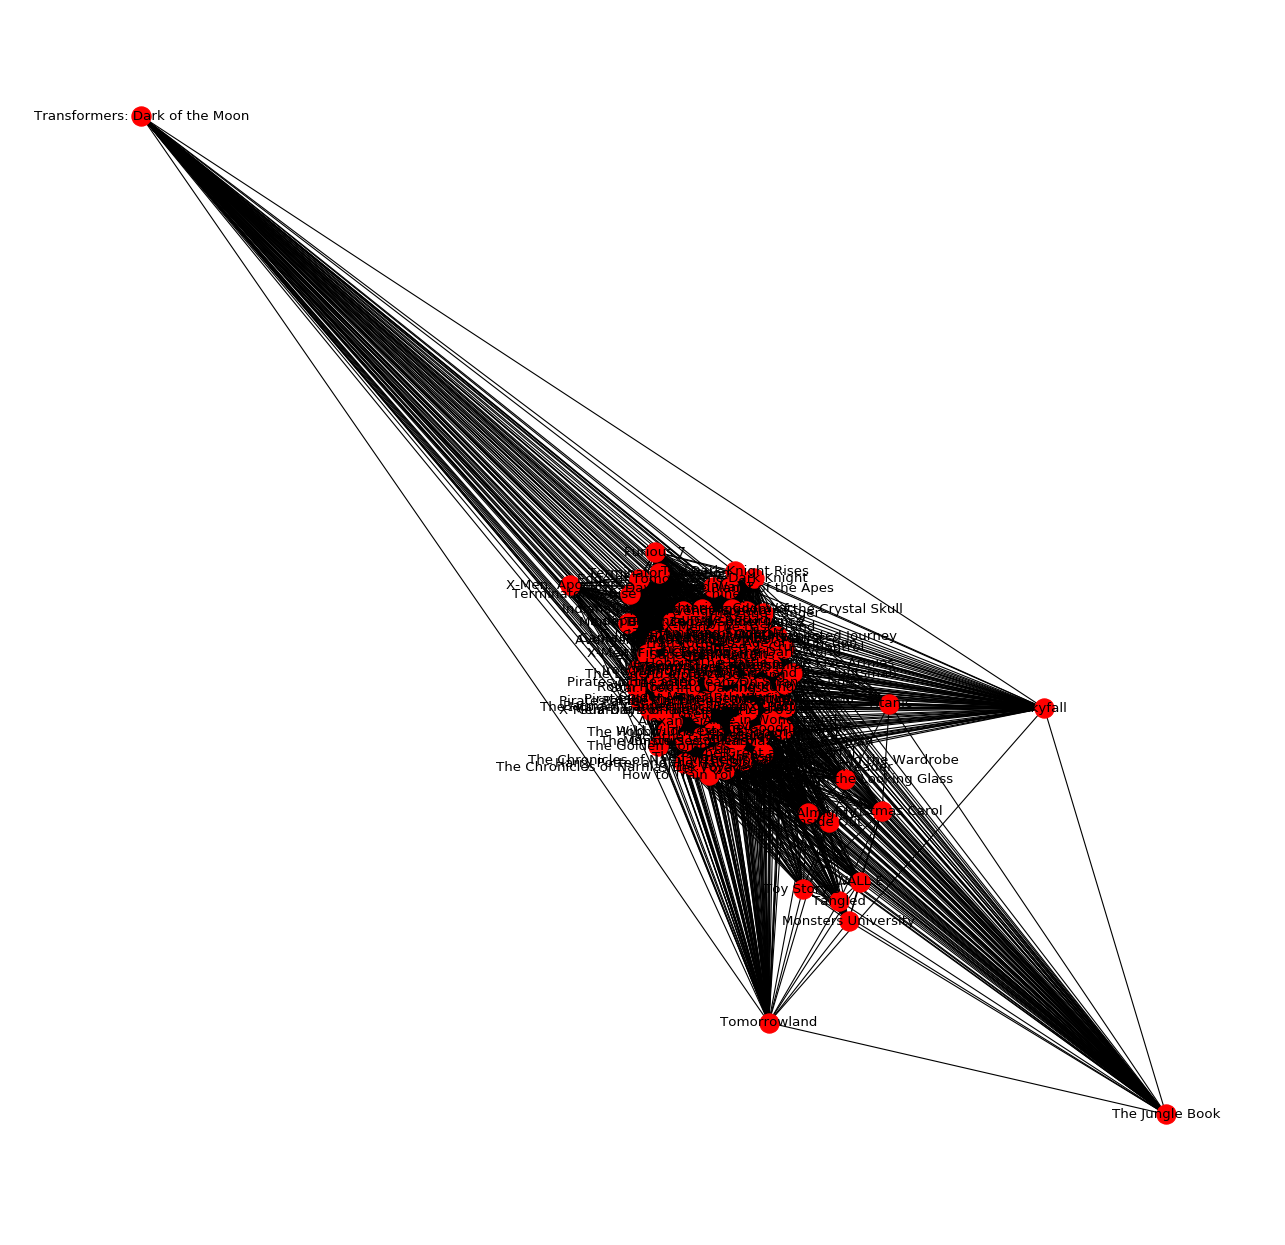


Movies recommendations
 [('The Dark Knight', 'Tomorrowland'), ('The Dark Knight', 'Monsters vs Aliens'), ('Jack the Giant Slayer', 'Troy'), ('The Dark Knight Rises', 'Monsters vs Aliens'), ('Men in Black 3', 'Oz: The Great and Powerful'), ('Men in Black 3', 'Hugo')]

Genre recommendations
 [('Drama', 'Mystery'), ('Crime', 'Animation'), ('Fantasy', 'Thriller')]


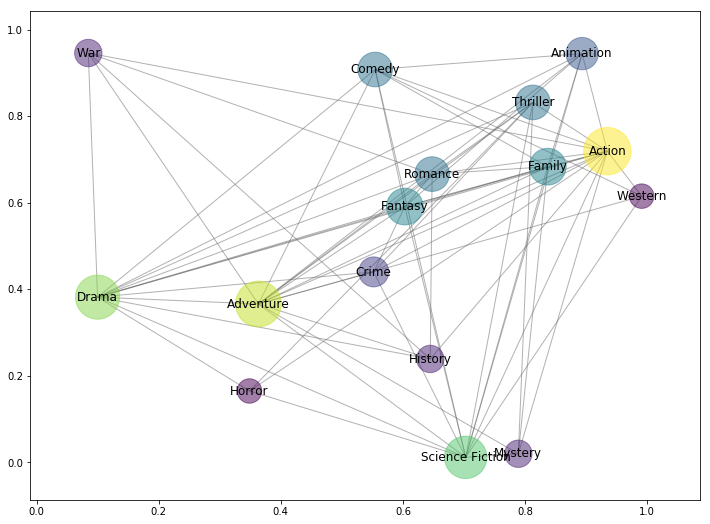


Movies which are similar to each other on weighted graph


Movies recommendations on weighted graph
 [('The Dark Knight', 'Tomorrowland'), ('The Dark Knight', 'Monsters vs Aliens'), ('Jack the Giant Slayer', 'Troy'), ('The Dark Knight Rises', 'Monsters vs Aliens'), ('Men in Black 3', 'Oz: The Great and Powerful'), ('Men in Black 3', 'Hugo')]


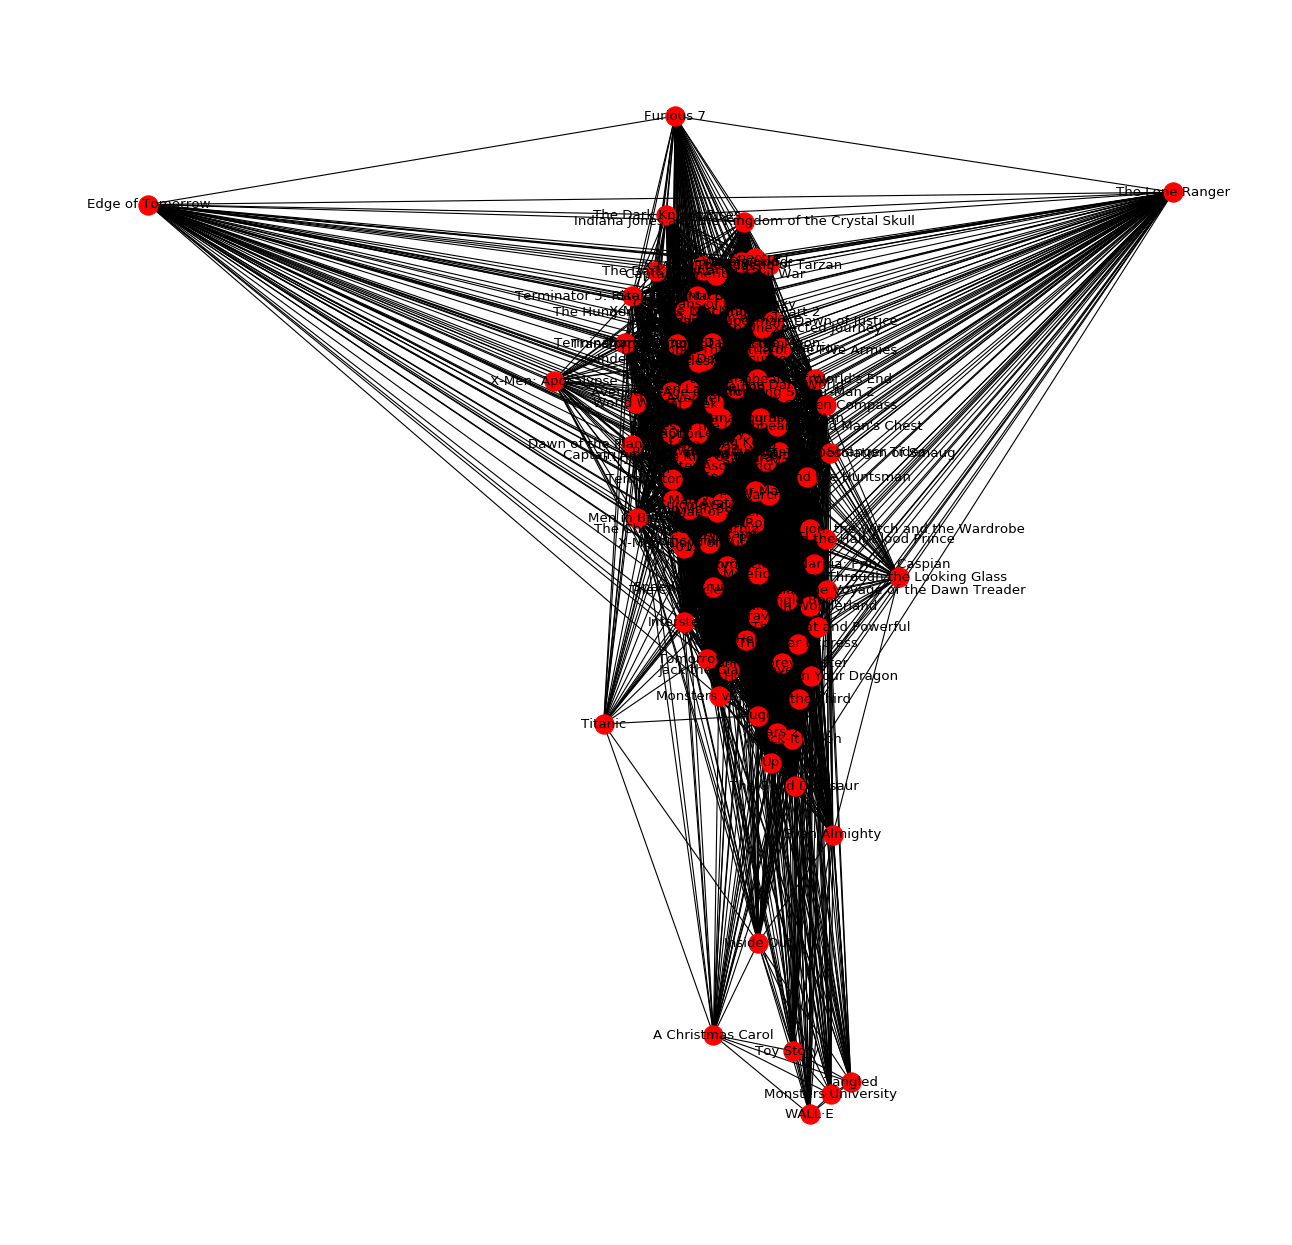


Genre which are similar to each other on weighted graph



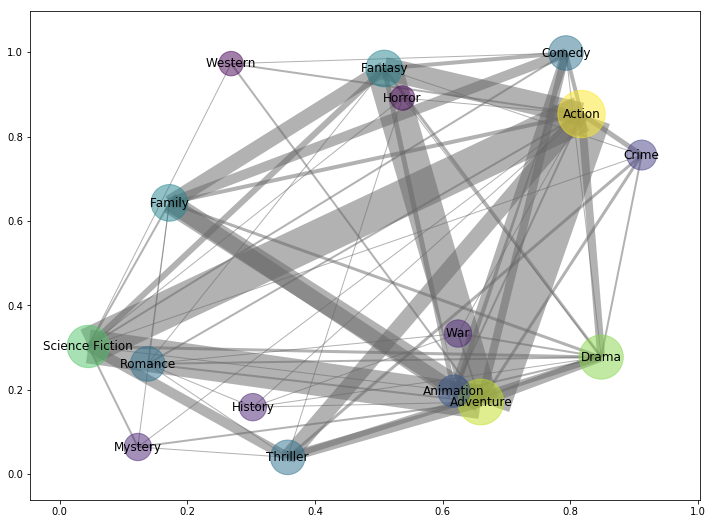


Genre recommendations on weighted graph
 [('Drama', 'Mystery'), ('Crime', 'Animation'), ('Fantasy', 'Thriller')]
Projections using Vote count:

13752

Node information:Name: 
Type: Graph
Number of nodes: 29
Number of edges: 59
Average degree:   4.0690

Graph Diameter:6

Graph Radius:4


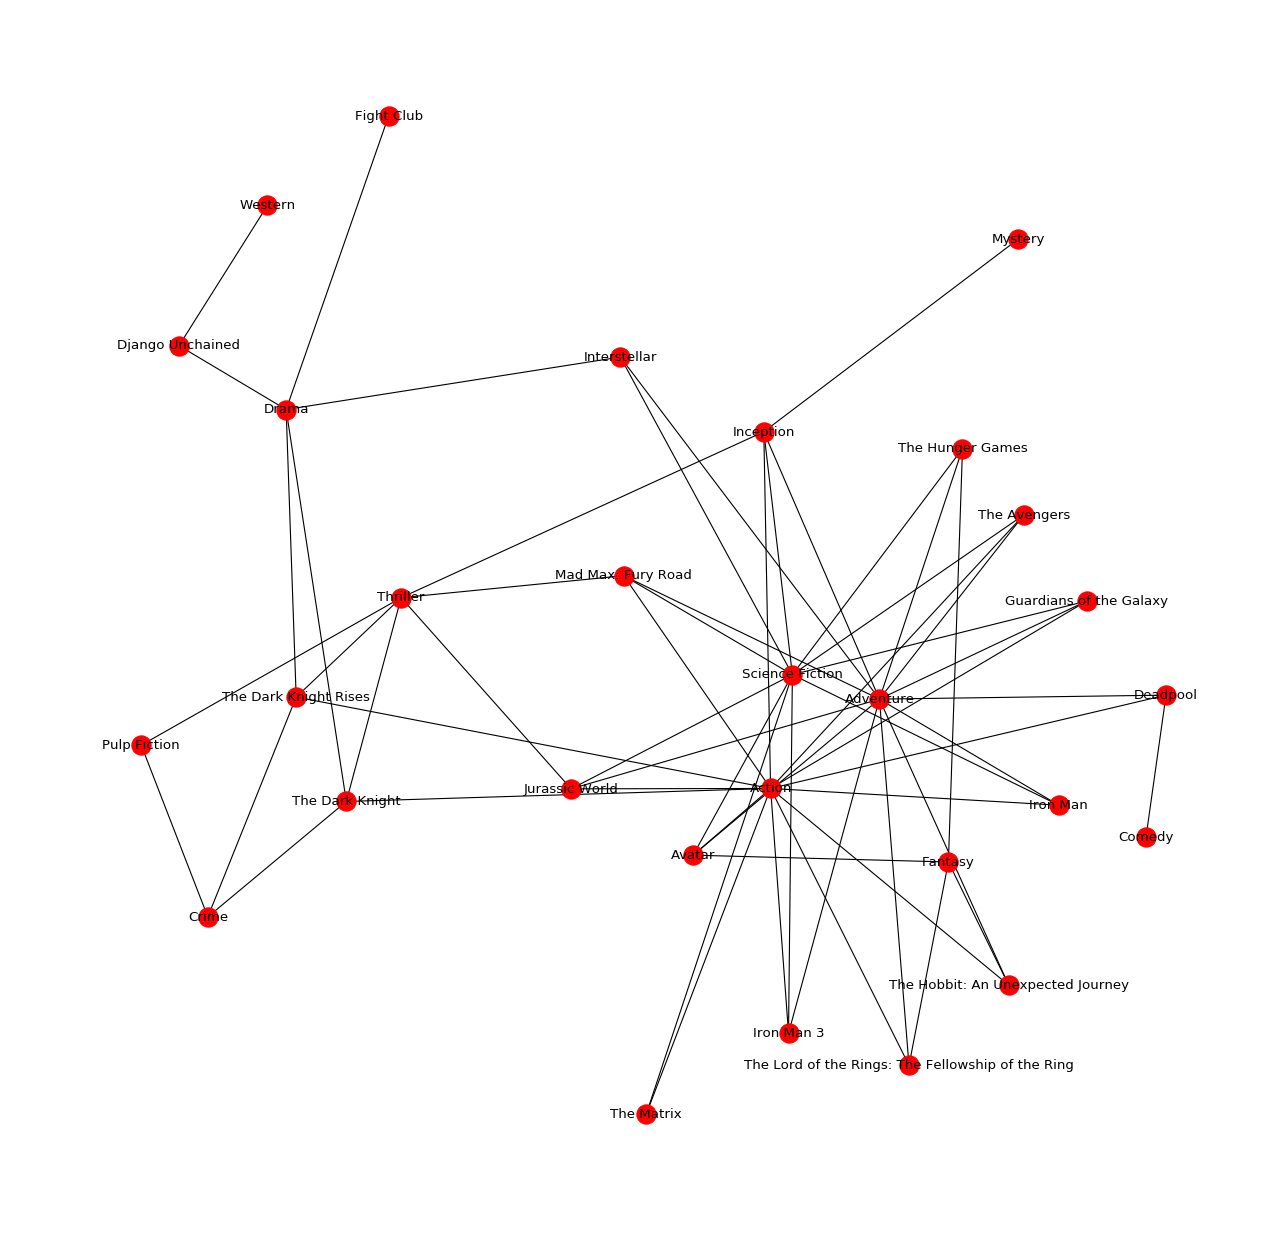


Movies which are similar to each other



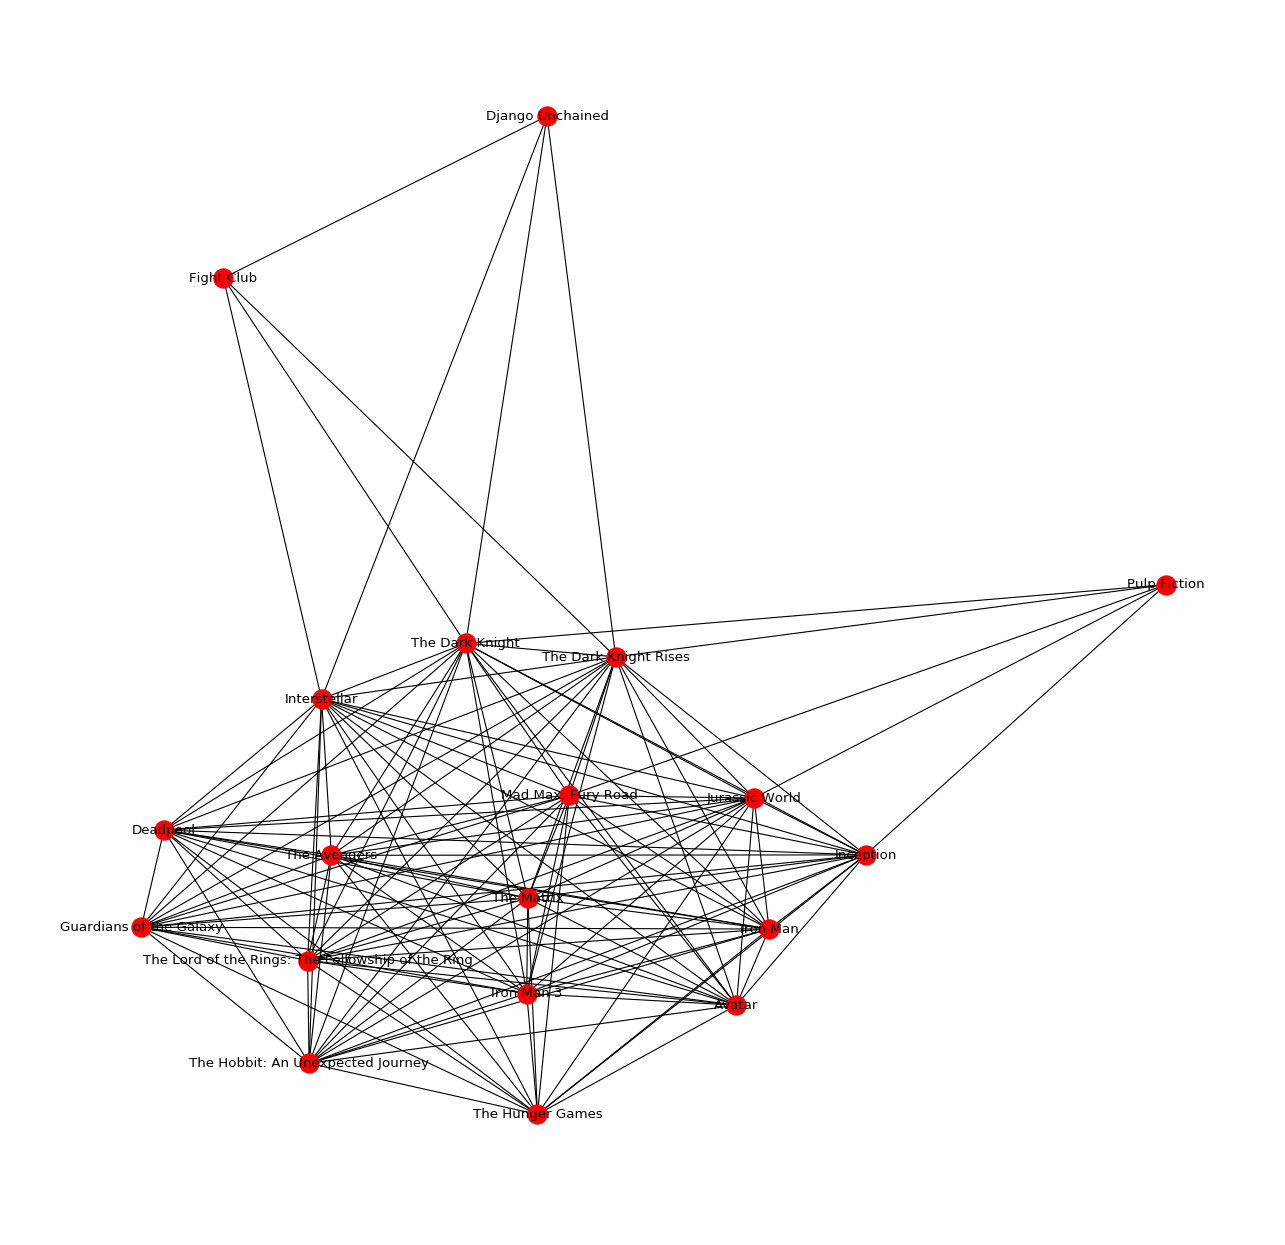


Movies recommendations
 [('Avatar', 'Pulp Fiction'), ('Interstellar', 'Pulp Fiction'), ('The Avengers', 'Pulp Fiction'), ('Iron Man', 'Pulp Fiction'), ('The Matrix', 'Pulp Fiction'), ('Pulp Fiction', 'Deadpool'), ('Pulp Fiction', 'The Lord of the Rings: The Fellowship of the Ring'), ('The Dark Knight Rises', 'The Hunger Games'), ('The Dark Knight', 'The Hunger Games')]

Genre recommendations
 [('Fantasy', 'Drama'), ('Fantasy', 'Mystery'), ('Fantasy', 'Thriller'), ('Science Fiction', 'Crime'), ('Drama', 'Mystery')]


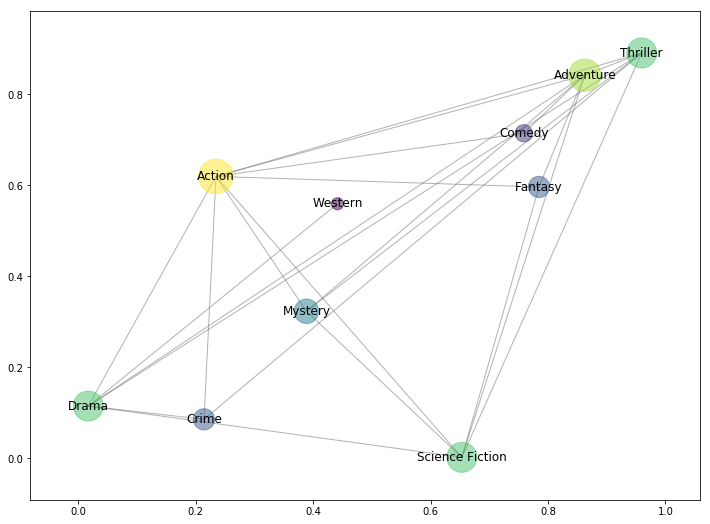


Movies which are similar to each other on weighted graph


Movies recommendations on weighted graph
 [('Avatar', 'Pulp Fiction'), ('Interstellar', 'Pulp Fiction'), ('The Avengers', 'Pulp Fiction'), ('Iron Man', 'Pulp Fiction'), ('The Matrix', 'Pulp Fiction'), ('Pulp Fiction', 'Deadpool'), ('Pulp Fiction', 'The Lord of the Rings: The Fellowship of the Ring'), ('The Dark Knight Rises', 'The Hunger Games'), ('The Dark Knight', 'The Hunger Games')]


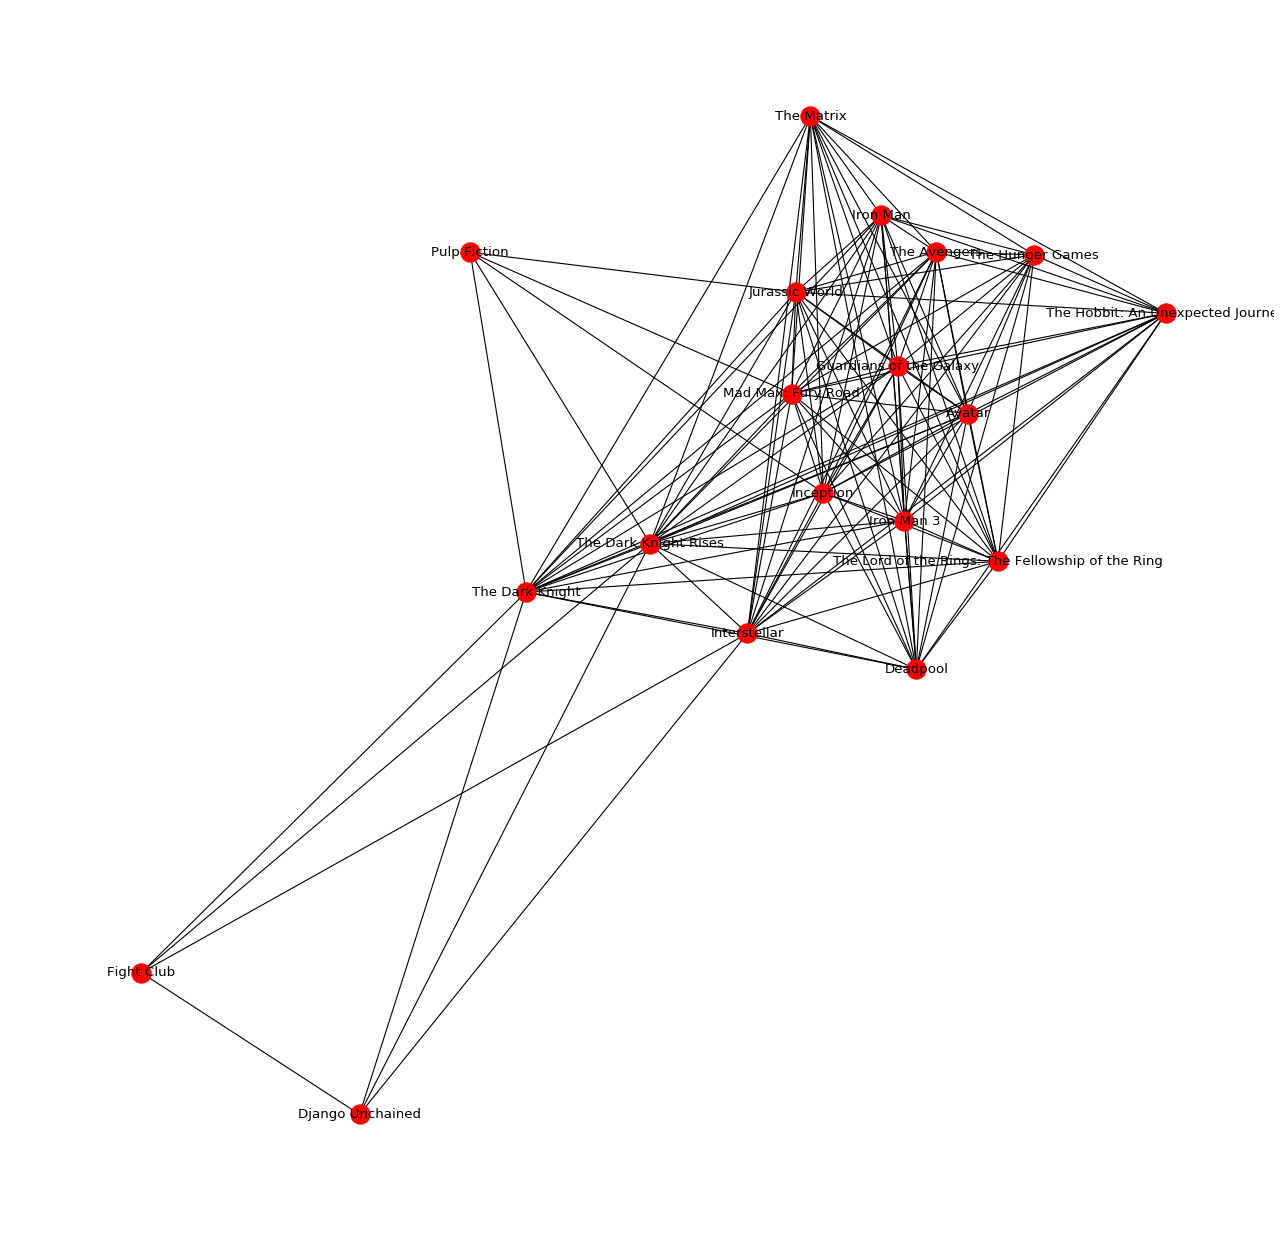


Genre which are similar to each other on weighted graph



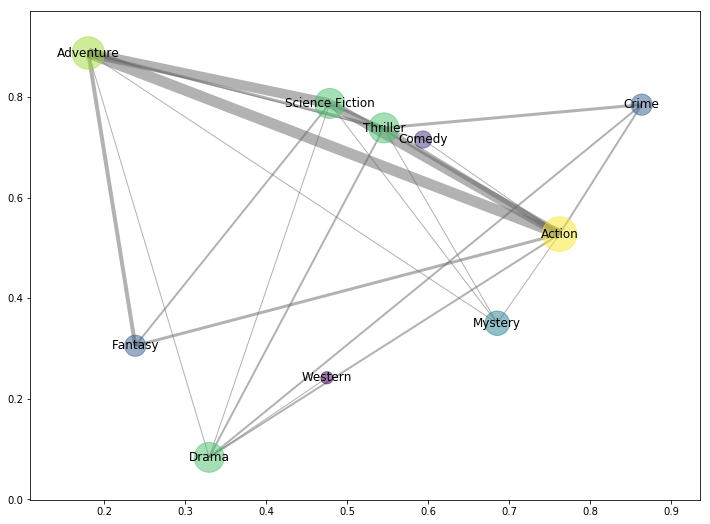


Genre recommendations on weighted graph
 [('Fantasy', 'Drama'), ('Fantasy', 'Mystery'), ('Fantasy', 'Thriller'), ('Science Fiction', 'Crime'), ('Drama', 'Mystery')]


In [174]:
if __name__ == "__main__":
    
    # Loading dataset and required columns
    df = pd.read_csv('./data/tmdb_5000_movies.csv',sep=',')[['genres','homepage','title','vote_average','popularity','budget','vote_count','original_language']]

    df['genres'] = df['genres'].apply(json.loads)
    df['genres']  = df['genres'].apply(pipe_flatten_names)

    g = nx.Graph()

    # Seperating Moviews and genre
    movie_list =[]
    genre_list = []

    for index,data in df.iterrows():
        #Movie
        g.add_node(data[2],bipartite="Movies")
        movie_list.append(data[2])
        #Genre
        for genre in data[0].split('|'):
            genre_list.append(genre)
            g.add_node(genre,bipartite="Genre")
            g.add_edge(data[2],genre,vote_average =data[3],popularity=data[4], \
                  budget=data[5],vote_count=data[6])
        
    
    # Calling the analysis using budget column
    print("Projections using Budget:\n")
    island_budget = helping_function(g,'budget')
    #island_popularity = helping_function(g,'popularity')
    #island_vote_avg= helping_function(g,'vote_average')
    
    # Calling the analysis using vote count
    print("Projections using Vote count:\n")
    island_vote_cnt = helping_function(g,'vote_count')
    

# Summary

1. We have performed out analysis on two different measures budget and vote count.
2. As a intial step, we have loaded the dataset and assigned proper bipartitie category.
3. As the dataset is huge, we reduced the dataset using islands of net method. This reduced the node and edges data.
4. Once dataset is reduced, we have perfomed the graph projections on the movies and genre. We also added weights to it.
5. After the weights we have plotted the smaller graph object.
6. Finally we have also recommended the top 10 movies and genre depending on users favorites.